In [1]:
!pip install -q transformers

In [2]:
!pip install -q datasets

In [3]:
!pip install -q huggingface_hub

In [4]:
!pip install -q phonemizer

In [5]:
!pip search espeak
!pip install py-espeak-ng
!sudo apt-get install python-espeak
!sudo apt-get update && sudo apt-get install espeak

ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI's XMLRPC API is currently disabled due to unmanageable load and will be deprecated in the near future. See https://status.python.org/ for more information.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-espeak is already the newest version (0.5-1build5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 http://archive.ubun

In [6]:
import json
import torch
import re
import random
import phonemizer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from huggingface_hub import hf_hub_download
from datasets import load_dataset, Audio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2Tokenizer, Wav2Vec2Config

In [7]:
config = Wav2Vec2Config.from_pretrained("facebook/wav2vec2-xlsr-53-espeak-cv-ft", output_hidden_states=True)
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-xlsr-53-espeak-cv-ft", config=config)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-xlsr-53-espeak-cv-ft")

In [8]:
_file = hf_hub_download(repo_id="facebook/wav2vec2-xlsr-53-espeak-cv-ft", filename="vocab.json")
with open(_file, 'r') as f:
  vocab = json.loads(f.read())
convenient_vocab = {}
for k, v in vocab.items():
  convenient_vocab[v] = k

In [9]:
librispeech_samples_ds = load_dataset("common_voice", 'ru', split="validation")
librispeech_samples_ds = librispeech_samples_ds.cast_column("audio", Audio(sampling_rate=16_000))

Reusing dataset common_voice (/root/.cache/huggingface/datasets/common_voice/ru/6.1.0/a1dc74461f6c839bfe1e8cf1262fd4cf24297e3fbd4087a711bd090779023a5e)


In [10]:
vowels = set(['ɪ', 'uː', 'ʌ', 'iː', 'ɛ', 'ɑː', 'ə', 'i', 'oʊ', 'æ', 'ɐ', 'aʊ', 'ʊ', 'aɪ', 'eɪ', 'oː', 'a', 'oɪ', 'ɔ', 'ɚ', 'eː', 'ᵻ', 'o', 'aː', 'e', 'ɑ', 'u'])
voiced = set(['b', 'd', 'dʒ', 'j', 'l', 'm', 'n', 'v', 'w', 'z', 'ɡ', 'ɲ', 'əl', 'ɹ', 'ɾ', 'ʒ', 'ŋ', 'ð', 'r'])
voiceless = set(['f', 'h', 'k', 'p', 's', 't', 'ts', 'tʃ', 'ʃ', 'θ'])
consonants = voiced.union(voiceless)
soft = set(['dʲ', 'j', 'mʲ', 'nʲ', 'rʲ', 'sʲ', 'tʲ', 'ɭʲ', 'ɟ', 'ç'])
hard = consonants - soft

## Первый этап: сбор данных

Для сбора данных я создала две функции. 
- *sound_vectors* создаёт список словарей. В каждом словаре ключами являются угаданные моделью звуки, а значениями - список векторов соответствующего звука. Для каждого слоя создаётся отдельный словарь.
- *sound_vectors_nears* создаёт аналогичный список словарей. Помимо него, создаётся словарь, где записываются звука, окружающие обрабатывающийся на данный момент звук. Таким образом, для каждого звука получается два списка: список векторов и список окружающих звуков.

In [11]:
def sound_vectors(n, layer, predicted_ids):
  sound_vectors = defaultdict(list)
  numpy_logits = layer[0].detach().numpy()
  num = 0
  for i in range(len(predicted_ids[0])):
    if predicted_ids[0][i] not in [1, 2, 3, 0]:
      num += 1
      all_sound_vectors[n][convenient_vocab[predicted_ids[0][i]]].append(numpy_logits[i])

In [12]:
def sound_vectors_nears(n, layer, predicted_ids):
  sound_vectors = defaultdict(list)
  numpy_logits = layer[0].detach().numpy()
  transcription = processor.batch_decode(predicted_ids)[0].split()
  ids = predicted_ids[0]
  needed_ids = []
  logits = []
  for i in range(1, len(ids)):
    if ids[i] not in [0,1,2,3]:
      if ids[i] != ids[i-1]:
        needed_ids.append(ids[i])
        logits.append(numpy_logits[i])
  for i in range(len(needed_ids)):
    if n == 25:
      try:
        if i == 0:
          all_near_sounds[convenient_vocab[needed_ids[i]]].append(['sound', transcription[i+1],transcription[i+2]])
          all_sound_vectors2[n][convenient_vocab[needed_ids[i]]].append(logits[i])
        elif i == len(transcription)-1:
          all_near_sounds[convenient_vocab[needed_ids[i]]].append([transcription[i-2], transcription[i-1], 'sound'])
          all_sound_vectors2[n][convenient_vocab[needed_ids[i]]].append(logits[i])
        elif i == 1:
          all_near_sounds[convenient_vocab[needed_ids[i]]].append([transcription[i-1], 'sound', transcription[i+1], transcription[i+2]])
          all_sound_vectors2[n][convenient_vocab[needed_ids[i]]].append(logits[i])
        elif i == len(transcription)-2:
          all_near_sounds[convenient_vocab[needed_ids[i]]].append([transcription[i-2], transcription[i-1], 'sound', transcription[i+1]])
          all_sound_vectors2[n][convenient_vocab[needed_ids[i]]].append(logits[i])
        else:
          all_near_sounds[convenient_vocab[needed_ids[i]]].append([transcription[i-2], transcription[i-1], 'sound', transcription[i+1], transcription[i+2]])
          all_sound_vectors2[n][convenient_vocab[needed_ids[i]]].append(logits[i])
      except:
        print(transcription)

In [13]:
all_sound_vectors2 = [defaultdict(list) for i in range(26)]
all_sound_vectors = [defaultdict(list) for i in range(26)]
all_near_sounds = defaultdict(list)
layers = []
texts = []
all_sounds = defaultdict(list)

In [14]:
i = 0
for audio in tqdm(librispeech_samples_ds):
  i += 1
  if i == 300:
    break
  audio_input = audio['audio']['array']
  sample_rate = audio['audio']['sampling_rate']
  texts.append(audio['sentence'])
  all_sounds[audio['sentence']].append(audio_input)
  input_values = processor(audio_input, sampling_rate=sample_rate, return_tensors="pt").input_values
  with torch.no_grad():
    outputs = model(input_values.float())
    logits = outputs.logits
    hidden_states = outputs.hidden_states
    layers.extend(hidden_states)
    layers.append(logits)
  predicted_ids = torch.argmax(logits, dim=-1).detach().numpy()
  for n, layer in enumerate(layers):
    sound_vectors(n, layer, predicted_ids)
    sound_vectors_nears(n, layer, predicted_ids)
  layers = []

  3%|▎         | 253/7963 [19:45<6:50:21,  3.19s/it]

['ɡ', 'o']


  4%|▍         | 299/7963 [23:50<10:10:54,  4.78s/it]


## Второй этап: тесты

Функция для изображения данных:
- *draw_coefs* рисует графики наибольших по модулю коэффициентов модели.
- *draw_accuracy* рисует график значений accuracy на каждом слое

In [15]:
def draw_coefs(model, testname):
  '''
  model -> используемая модель LogReg
  testname -> название теста
  '''
  all_coefs = np.argsort(model.coef_[0])
  need_coefs = all_coefs[:10].tolist() + all_coefs[-10:].tolist()
  sounds = []
  coefs = []
  for coef in need_coefs:
    sounds.append(convenient_vocab[coef])
    coefs.append(model.coef_[0][coef])
  plt.figure(figsize=(7, 5))
  plt.bar(sounds, coefs)
  plt.xlabel('Звуки')
  plt.ylabel('Коэффициенты')
  plt.title(f'Звуки с наибольшими и наименьшими коэффициентами\nлогистической регрессии, тест: {testname}')

In [16]:
def draw_accuracy(dict_of_scores):
  '''
  dict_of_scores -> словарь, в котором ключом является тип перемешивания,
  а значением список значений accuracy
  '''
  xs = [i for i in range(1, 27)]
  for k, v in dict_of_scores.items():
    plt.plot(xs, v, label=k)
  plt.legend()
  plt.title('Accuracy предсказания звонкости звука на каждом из слоёв')
  plt.xlabel('Номер слоя')
  plt.ylabel('Значение accuracy')

В каждом из разделов по тестам первая ячейка создаёт список векторов и список классов для каждого вектора. В первом блоке собираются верные данные, во втором блоке собираются данные для группового перемешивания, в третьем - для полного.

После каждый из списков данных подаётся на обучение модели. В результате получаются три списка значений accuracy для каждого из тестов на каждом из слоёв модели.

### Звонкость / глухость

In [21]:
voiced_or_not = []
list_of_vectors2 = []
for i in range(26):
  one_of_the_lists = []
  for k, v in all_sound_vectors[i].items():
    if k in consonants:
      one_of_the_lists.extend(v)
      if i == 0:
        if k in voiced:
          voiced_or_not.extend(['voiced']*len(v))
        else:
          voiced_or_not.extend(['voiceless']*len(v))
  list_of_vectors2.append(one_of_the_lists)
  one_of_the_lists = []

rand_voiced_or_not = []
listik = ['voiced', 'voiceless']
voice_cnt = 0
ans_voice = {}
for i in range(26):
  one_of_the_lists = []
  for k, v in all_sound_vectors[i].items():
    if k in consonants:
      what = random.choice(listik)
      ans_voice[k] = what
      if i == 0:
        if what == 'voiced':
          rand_voiced_or_not.extend(['voiced']*len(v))
          voice_cnt += 1
          if voice_cnt == len(voiced):
            listik = ['voiceless']
        else:
          rand_voiced_or_not.extend(['voiceless']*len(v))

full_rand_voice = [el for el in voiced_or_not]
random.shuffle(full_rand_voice)

In [22]:
scores_voice = []
for i in tqdm(range(26)):
  modell_right_voice = LogisticRegression(max_iter=10000)
  X_train , X_test , Y_train , Y_test = train_test_split(list_of_vectors2[i],voiced_or_not,train_size = .8)
  under_sampler = RandomUnderSampler(random_state=42)
  X_res, y_res = under_sampler.fit_resample(X_train, Y_train)
  modell_right_voice.fit(X_res, y_res)
  score = modell_right_voice.score(X_test, Y_test)
  scores_voice.append(score)

scores_rn_voice = []
for i in tqdm(range(26)):
  modell_wr_voice = LogisticRegression(max_iter=10000)
  x_train , x_test , y_train , y_test = train_test_split(list_of_vectors2[i],rand_voiced_or_not,train_size = .8)
  under_sampler = RandomUnderSampler(random_state=42)
  X_res, y_res = under_sampler.fit_resample(x_train, y_train)
  modell_wr_voice.fit(X_res, y_res)
  score = modell_wr_voice.score(x_test, y_test)
  scores_rn_voice.append(score)

full_rn_voice = []
for i in tqdm(range(26)):
  modell_fr_voice = LogisticRegression(max_iter=10000)
  x_train , x_test , y_train , y_test = train_test_split(list_of_vectors2[i],full_rand_voice,train_size = .8)
  under_sampler = RandomUnderSampler(random_state=42)
  X_res, y_res = under_sampler.fit_resample(x_train, y_train)
  modell_fr_voice.fit(X_res, y_res)
  score = modell_fr_voice.score(x_test, y_test)
  full_rn_voice.append(score)

100%|██████████| 26/26 [04:20<00:00, 10.02s/it]


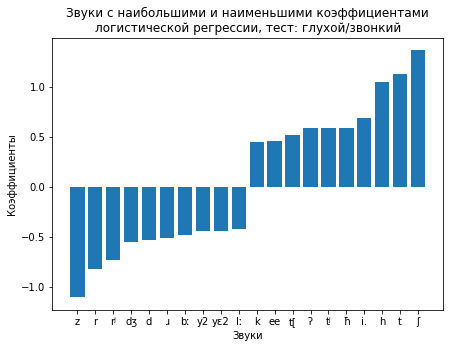

In [23]:
draw_coefs(modell_right_voice, 'глухой/звонкий')

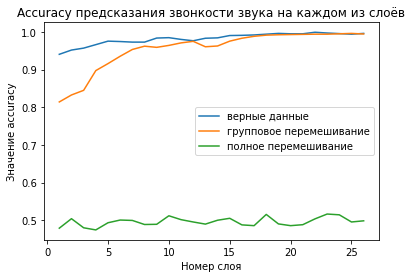

In [26]:
dict_of_scores = {'верные данные': scores_voice,
                  'групповое перемешивание': scores_rn_voice,
                  'полное перемешивание': full_rn_voice}
draw_accuracy(dict_of_scores)

### Гласный / согласный

In [17]:
vow_cons = []
list_of_vectors = []
for i in range(26):
  one_of_the_lists = []
  for k, v in all_sound_vectors[i].items():
    one_of_the_lists.extend(v)
    if i == 0:
      if k in vowels:
        vow_cons.extend(['vowel']*len(v))
      else:
        vow_cons.extend(['consonant']*len(v))
  list_of_vectors.append(one_of_the_lists)
  one_of_the_lists = []

rand_vow_cons = []
vow_cnt = 0
listik = ['vowel', 'consonant']
ans_vow_cons = {}
for i in range(26):
  for k, v in all_sound_vectors[i].items():
    if i == 0:
      what = random.choice(listik)
      ans_vow_cons[k] = what
      if what == 'vowel':
        rand_vow_cons.extend(['vowel']*len(v))
        vow_cnt += 1
        if vow_cnt == len(vowels):
          listik = ['consonant']
      else:
        rand_vow_cons.extend(['consonant']*len(v))

full_rand = [el for el in vow_cons]
random.shuffle(full_rand)

In [18]:
scores = []
for i in tqdm(range(26)):
  modell_right = LogisticRegression(max_iter=10000)
  X_train , X_test , Y_train , Y_test = train_test_split(list_of_vectors[i],vow_cons,train_size = .8)
  under_sampler = RandomUnderSampler(random_state=42)
  X_res, y_res = under_sampler.fit_resample(X_train, Y_train)
  modell_right.fit(X_res, y_res)
  score = modell_right.score(X_test, Y_test)
  scores.append(score)

scores_rn = []
for i in tqdm(range(26)):
  modell_rn = LogisticRegression(max_iter=10000)
  x_train , x_test , y_train , y_test = train_test_split(list_of_vectors[i],rand_vow_cons,train_size = .8)
  under_sampler = RandomUnderSampler(random_state=42)
  X_res, y_res = under_sampler.fit_resample(x_train, y_train)
  modell_rn.fit(x_train, y_train)
  score = modell_rn.score(X_res, y_res)
  scores_rn.append(score)

full_rn = []
for i in tqdm(range(26)):
  modell = LogisticRegression(max_iter=10000)
  x_train , x_test , y_train , y_test = train_test_split(list_of_vectors[i],full_rand,train_size = .8)
  under_sampler = RandomUnderSampler(random_state=42)
  X_res, y_res = under_sampler.fit_resample(x_train, y_train)
  modell.fit(X_res, y_res)
  score = modell.score(x_test, y_test)
  full_rn.append(score)

100%|██████████| 26/26 [04:51<00:00, 11.20s/it]


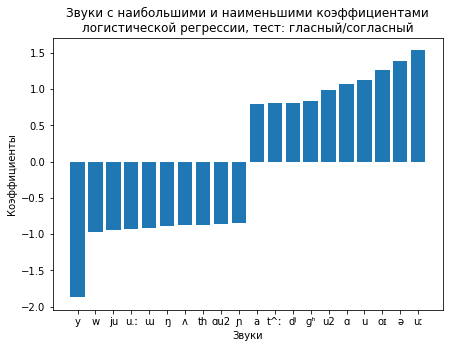

In [19]:
draw_coefs(modell_right, 'гласный/согласный')

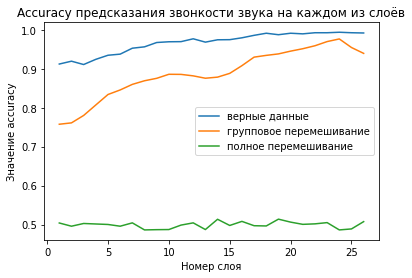

In [20]:
dict_of_scores = {'верные данные': scores,
                  'групповое перемешивание': scores_rn,
                  'полное перемешивание': full_rn}
draw_accuracy(dict_of_scores)

### Мягкий / твёрдый

In [21]:
soft_hard = []
list_of_vectors = []
for i in range(26):
  one_of_the_lists = []
  for k, v in all_sound_vectors[i].items():
    if k not in vowels:
      one_of_the_lists.extend(v)
      if i == 0:
        if k in soft:
          # print(k)
          soft_hard.extend(['soft']*len(v))
        else:
          soft_hard.extend(['hard']*len(v))
  list_of_vectors.append(one_of_the_lists)
  one_of_the_lists = []

rand_soft_hard = []
ans_soft = {}
soft_cnt = 0
listik = ['soft', 'hard']
for i in range(26):
  one_of_the_lists = []
  for k, v in all_sound_vectors[i].items():
    if k not in vowels:
      one_of_the_lists.extend(v)
      if i == 0:
        what = random.choice(listik)
        ans_soft[k] = what
        if what == 'soft':
          rand_soft_hard.extend(['soft']*len(v))
          soft_cnt += 1
          if soft_cnt == len(soft):
            listik = ['hard']
        else:
          rand_soft_hard.extend(['hard']*len(v))
  list_of_vectors.append(one_of_the_lists)
  one_of_the_lists = []

full_rand = [el for el in soft_hard]
random.shuffle(full_rand)

In [22]:
scores = []
for i in tqdm(range(26)):
  modell_smart = LogisticRegression(max_iter=10000)
  X_train , X_test , Y_train , Y_test = train_test_split(list_of_vectors[i],soft_hard,train_size = .8, random_state=1)
  under_sampler = RandomUnderSampler(random_state=42)
  X_res, y_res = under_sampler.fit_resample(X_train, Y_train)
  modell_smart.fit(X_res, y_res)
  score = modell_smart.score(X_test, Y_test)
  scores.append(score)

scores_rn = []
for i in tqdm(range(26)):
  modell_rn = LogisticRegression(max_iter=10000)
  x_train_rn , x_test_rn , y_train_rn , y_test_rn = train_test_split(list_of_vectors[i],rand_soft_hard,train_size = .8, random_state=1)
  under_sampler = RandomUnderSampler(random_state=42)
  X_res, y_res = under_sampler.fit_resample(x_train_rn, y_train_rn)
  modell_rn.fit(X_res, y_res)
  score = modell_rn.score(x_test_rn, y_test_rn)
  scores_rn.append(score)

full_rn = []
for i in tqdm(range(26)):
  modell = LogisticRegression(max_iter=10000)
  x_train , x_test , y_train , y_test = train_test_split(list_of_vectors[i],full_rand,train_size = .8, random_state=1)
  under_sampler = RandomUnderSampler(random_state=42)
  X_res, y_res = under_sampler.fit_resample(x_train, y_train)
  modell.fit(X_res, y_res)
  score = modell.score(x_test, y_test)
  full_rn.append(score)

100%|██████████| 26/26 [01:08<00:00,  2.65s/it]


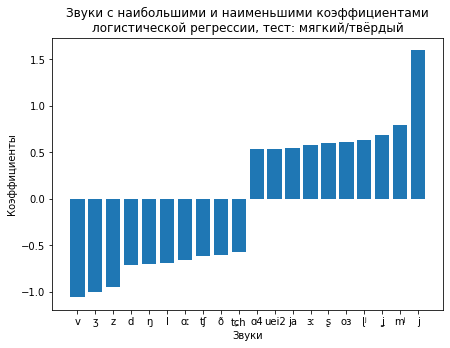

In [24]:
draw_coefs(modell_smart, 'мягкий/твёрдый')

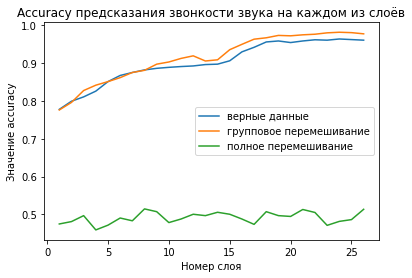

In [23]:
dict_of_scores = {'верные данные': scores,
                  'групповое перемешивание': scores_rn,
                  'полное перемешивание': full_rn}
draw_accuracy(dict_of_scores)

### Третий этап: создание таблицы с окружающими звуками

Эта таблица используется для проверки звуков, которые окружают исследуемый

In [25]:
dataset = []
for k, v in all_sound_vectors2[-1].items():
  for i in range(len(v)):
    try:
      dataset.append([k, v[i], all_near_sounds[k][i]])
    except:
      print(k, i)

df = pd.DataFrame(dataset, columns=['sound', 'vector', 'near_sounds'])

In [26]:
def softness(sound):
  if sound in soft:
    return 'soft'
  elif sound in hard:
    return 'hard'
  return 'vowel'

In [27]:
df['softness'] = df['sound'].apply(softness)
df_new = df.copy()
df_new = df_new[df_new['softness']!='vowel']

In [28]:
modell_smart = LogisticRegression(max_iter=10000)
X_train , X_test , Y_train , Y_test = train_test_split(df_new['vector'].tolist(),df_new['softness'].tolist(),train_size = .8, random_state=1)
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X_train, Y_train)
modell_smart.fit(X_res, y_res)

LogisticRegression(max_iter=10000)

In [29]:
def predict_softness(vector):
  return modell_smart.predict(vector.reshape(1, -1))[0]

In [30]:
def model_thoughts(vector):
  s = np.argsort(vector)
  return [convenient_vocab[index] for index in s[-5:]]

In [31]:
df_new['prediction'] = df_new['vector'].apply(predict_softness)
df_new['model_thoughts'] = df_new['vector'].apply(model_thoughts)

In [32]:
df_new.head()

,sound,vector,near_sounds,softness,prediction,model_thoughts
0,p,"[1.0537665, -2.3217566, -2.3551805, -2.240635,...","[sound, ɛ, t]",hard,hard,"[k, t, pʲ, b, p]"
1,p,"[2.0440416, -3.637927, -3.7279046, -3.4571073,...","[n, a, sound, r, ʌ]",hard,hard,"[<pad>, k, t, b, p]"
2,p,"[1.4374672, -3.118083, -2.9388387, -2.7493403,...","[j, a, sound, t, x]",hard,hard,"[t, pʲ, k, b, p]"
3,p,"[1.5638765, -3.1817243, -3.0616622, -2.8506756...","[t, u, sound, l, e]",hard,hard,"[t, pʲ, k, b, p]"
4,p,"[1.6335026, -2.78596, -2.8287227, -2.590732, 0...","[e, i, sound, ɛ, t]",hard,hard,"[pʲ, t, k, b, p]"


### Исследование сходства звуков

Создание словаря, где ключи - это звуки, а значения - первые 20 элементов с наибольшими степенями уверенности в усреднённом векторе звука

In [ ]:
nears = {}
for key in all_sound_vectors[25].keys():
  s = np.argsort(np.mean(all_sound_vectors2[25][key], axis=0))
  nears[key] = [convenient_vocab[index] for index in s[-20:]]

### Сходства векторов

Создание таблицы, где строки и столбцы - это звуки, а пересечения - это степень уверенности модели, что звук строки похож на звук столбца

In [34]:
means = {}
keys = all_sound_vectors[25].keys()
for key in vocab.keys():
  if key in keys:
    values = all_sound_vectors[25][key]
    mean_val = np.mean(values, axis=0)
    means[key] = mean_val
  else:
   means[key] = np.zeros(392)

In [35]:
data = means
index = list(vocab.keys())
columns = list(vocab.keys())
df = pd.DataFrame(data=means, index=index, columns=columns)

Оставляю только те строки, которые встречаются в словаре модели Wav2Vec и делю данные на две таблицы: для гласных и для согласных

In [36]:
new_df = df.T
end = new_df[new_df['<s>']!=0]

In [38]:
vowel_cols = []
cons_cols = []
for col in end.columns:
  for sound in vowels:
    if col.startswith(sound):
      if col not in vowel_cols:
        vowel_cols.append(col)
for col in end.columns:
  if col not in vowel_cols:
    cons_cols.append(col)

In [39]:
df_vowels = pd.DataFrame(columns = end.columns)
df_cons = pd.DataFrame(columns = end.columns)

In [40]:
for i, row in end.iterrows():
  if i in vowel_cols:
    df_vowels.loc[i] = row
  else:
    df_cons.loc[i] = row

Дальше я чищу таблицу, чтобы избавиться от тех столбцов, большинство значений в которых очень низкие, то есть в основном нет звуков из словаря, которые были бы похожи на звук из столбца

In [41]:
del_cols_vows = []
del_cols_cons = []
for col in vowel_cols:
  if (df_vowels[col] < -1).sum() > (df_vowels[col] > -1).sum():
    del_cols_vows.append(col)
for col in cons_cols:
  if (df_cons[col] < 0).sum() > (df_cons[col] > -1.5).sum():
    del_cols_cons.append(col)
del_cols_cons.append('<s>')

In [42]:
needed_cols_vows = []
needed_cols_cons = []
for col in vowel_cols:
  if col not in del_cols_vows:
    needed_cols_vows.append(col)
for col in cons_cols:
  if col not in del_cols_cons:
    needed_cols_cons.append(col)

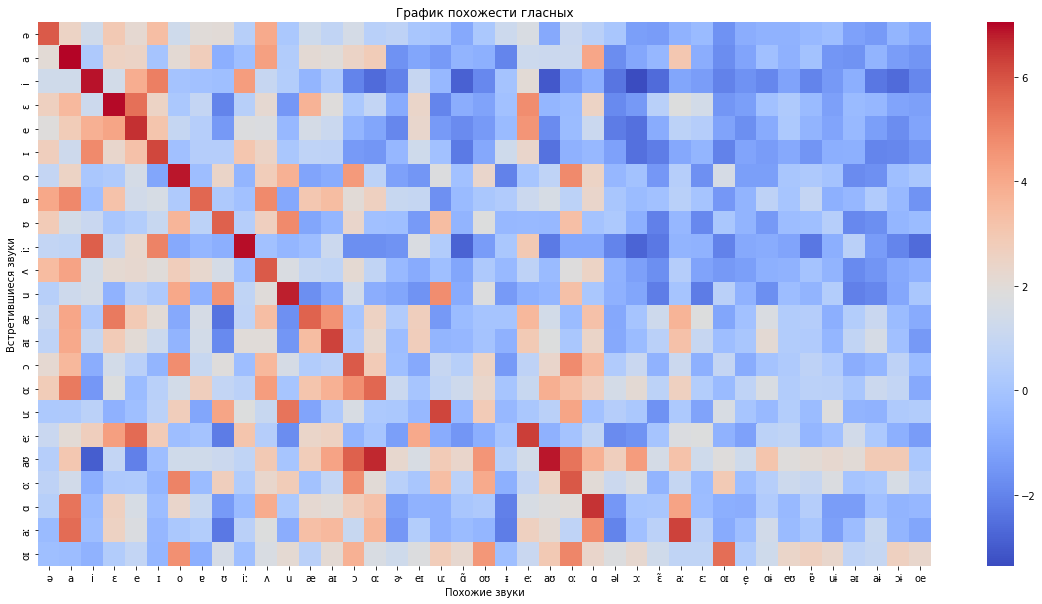

In [43]:
plt.figure(figsize=(20,10))
sns.heatmap(df_vowels[needed_cols_vows], cmap='coolwarm')
plt.xlabel('Похожие звуки')
plt.ylabel('Встретившиеся звуки')
plt.title('График похожести гласных')
plt.savefig(fname='a.pdf', format='pdf')

Text(0.5, 1.0, 'График похожести согласных')

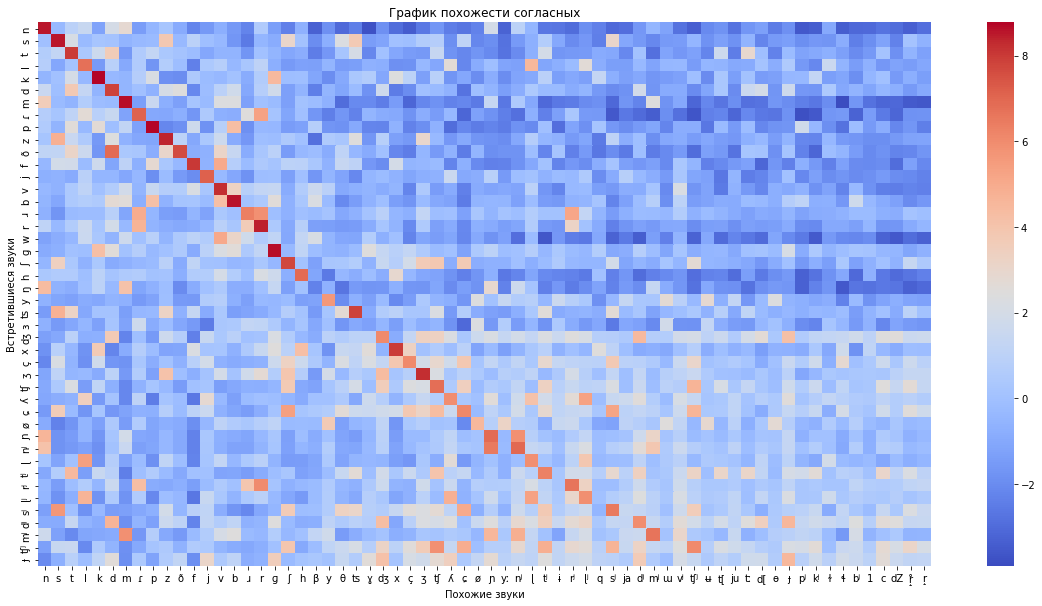

In [44]:
plt.figure(figsize=(20,10))
sns.heatmap(df_cons[needed_cols_cons], cmap='coolwarm')
plt.xlabel('Похожие звуки')
plt.ylabel('Встретившиеся звуки')
plt.title('График похожести согласных')

In [45]:
for k, v in nears.items():
  print(k)
  print(*v[-1::-1])

p
p b k t <pad> pʲ f m v β i n o ʋ pː q a ʌ tʲ d
ɛ
ɛ e eː æ a ə ɪ ɑ eɪ ʌ <pad> aɪ aː ɛː i ø ɐ ɑː œ ɜ
t
t d tː <pad> ts tʲ t[ k tʃ s p n ɾ z l θ c ð dʲ i
o
o oː ɔ u ʌ a ɑ ʊ oʊ <pad> uː ɵ oɪ e ɯ ʉ ə v aʊ ɭ
m
m n <pad> mʲ v b ŋ ɲ p u i l nʲ o ə f h a r e
u
u uː ʊ o oː y <pad> ɵ ʉ ʌ oʊ ɯ i ɔ a v w iː ɭ ũ
ʌ
ʌ a ə o <pad> ɑ ɐ e ɛ ɔ y ɪ oː ɯ u ʊ ʉ i æ ɑː
a
a ʌ ɑ aː ɑː ɐ ɛ ɔ e <pad> o æ ə aɪ eː aʊ oː ɜ v r
k
k ɡ <pad> x p t kː q kʲ ç tʲ tʃ ɾ ɣ kh r a f ʌ i
ʒ
ʒ dʒ z ʃ r tʃ S rʲ v y ʑ ɹ <pad> tʃʲ r̝ r̝̊ sʲ dʲ vʲ s
d
d t ð <pad> z d[ dʲ b ɡ ɟ dʒ tː n l v r ɖ ɫ ɭ t[
l
l ɭ <pad> ʎ ɭʲ ɫ r d v n z ɟ ɾ l̩ j o ɹ d[ t e
n
n <pad> m ŋ ɲ d l nʲ t r ə i z a e s mʲ ɭ iː p
v
v <pad> b f vʲ m β p ɡ ʌ r l w u ɭ y ɹ z ð h
ʃ
ʃ tʃ ɕ ʒ s tʃʲ <pad> s. S sʲ ç dʒ r̝̊ f z x ʂ ts ɨ r̝
y
y ɪ u i ʌ ʉ ɯ ʊ uː ɵ ø e o ə <pad> oː ɨ øː yː ja
b
b v p d ɡ m β bʲ ʋ <pad> pʲ vʲ mʲ ɟ w l bː k t u
r
r ɾ ɹ <pad> rʲ d l n v h ɭ t ʌ ʒ a ɡ b ɑ i dʒ
ɡ
ɡ k d b ɣ v ɟ <pad> kː eː dʒ ç r h ŋ ɲ j iː x dʲ
ɑ
ɑ a aː ʌ ɑː ɔ ɛ o æ oː aɪ aʊ <pad>